In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
from common_vars import *
import common_vars as cv
import imp
from pathlib import Path

from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import param_generation as pg
import _pickle as pickle
from IPython.display import Audio
from feature_extraction.mir_utils import *

import torch.utils.data as utils
import torchvision.transforms as transforms
from PIL import Image
import common_vars as comv
import sys
import csv
sys.path.append("..")

import helpers
imp.reload(helpers)
imp.reload(comv)
imp.reload(pg)
from feature_extraction import pytorch_models as tm
imp.reload(tm)
from helpers import *

from common_vars import SR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path="./generated_sample_pack/"
# device = "cpu"
stack_size=3
BATCH_SIZE=1
NUM_BINS=100

classes=comv.classes
classes_ranked=comv.classes_ranked
cDict={v:i for i,v in enumerate(classes)}

drum_groups=['tom_low','snare','hihat_closed','rim','synth_noise','clap','kick','hihat_open','tom_mid']


drum_df=pd.DataFrame(columns=["name","fc","cnnlstm","env+freq","consensus","stack_size"])



In [3]:
import feature_extraction.pytorch_models as pm
import imp

imp.reload(pm)

input_dim = 120
seq_dim=100
output_size = 5
hidden_dim = 1000
n_layers = 1

    
#########DVN#########
#env model stuff
env_model_dvn = tm.env_Model(D_in=10,H1=10,H2=5,H3=10,H4=2,H5=10,device=device)
state='./feature_extraction/models/fc/env_dvn_95_35.pt'
env_model_dvn.load_state_dict(torch.load(state))
env_trans=tm.envTrans()
env_model_dvn.to(device)


# pitch model stuff
fc_spec_model_dvn=tm.getFCSpecModel(D_in=20*20,H1=20,H2=10,H3=4,D_out=2)
state='./feature_extraction/models/fc/spec_fc_dvn_96.pt'
fc_spec_model_dvn.load_state_dict(torch.load(state))
fc_spec_trans_dvn=tm.specTrans(20)
fc_spec_model_dvn.to(device)

#cnn lstm
cnn_model_dvn=pm.CNNLSTM_dvn()
state='./feature_extraction/models/cnn/clst_dvn_96_279.pt'
cnn_model_dvn.load_state_dict(torch.load(state))
cnn_model_dvn.to(device)
cnn_model_dvn.to(device)
#########DVD#########
#fc dvd
dvd_fc=pm.getFCSpecModel(D_in=20*20,H1=100,H2=50,H3=100,D_out=len(drum_groups))
state='./feature_extraction/models/fc/spec_fc_dvd_81.pt'
dvd_fc.load_state_dict(torch.load(state))
dvd_fc.to(device)

#cnn_dvd
dvd_cnn=pm.CNNLSTM_dvd(len_out=len(drum_groups))
state='./feature_extraction/models/cnn/clst_dvd_90_170.pt'
dvd_cnn.load_state_dict(torch.load(state))
dvd_cnn.to(device)

#freq+env model
freq_env_model_dvd = tm.env_freq_Model(D_in=60,H1=30,H2=10,H3=10,D_out=len(drum_groups))
state='./feature_extraction/models/fc/freq_env_dvd_86_351.pt'
freq_env_model_dvd.load_state_dict(torch.load(state))
freq_env_trans=tm.freq_and_env_Trans(feat_mels=50,env_mels=1)
freq_env_model_dvd.to(device)



from IPython.display import Audio
import librosa.display

for g in drum_groups:
    Path(save_path+"/"+g).mkdir(parents=True, exist_ok=True)


env score 0.9630579948425293
fc_spec 0.009719480760395527
o_cnn_spec 0.00016039983893278986
fc category synth_noise 
cnn category synth_noise 
env+freq hihat_open
total consensus synth_noise
it took 109 iteration, stack size 2


<Figure size 864x216 with 0 Axes>

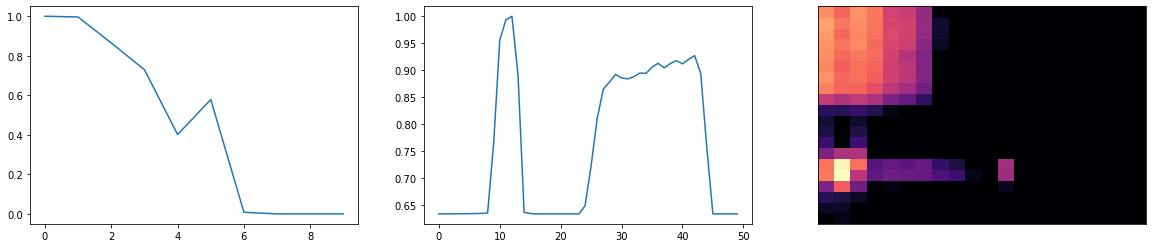

In [18]:
def findDrum(stack_size=1,iteration=0):
    out,params= stackMaker(stack_size)
    a= memToAud(out)
    try:
        a=librosa.util.normalize(a)
    except:
        pass
    transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
    env_feats=env_trans.call(transform_input)["feats"].to(device)
    freq_feats=freq_env_trans.call(transform_input)["feats"].to(device)
    pitch_feats=fc_spec_trans_dvn.call(transform_input)["feats"].to(device)
    spec_flat=torch.flatten(pitch_feats, start_dim=1)

    (params,a,
    outputEnvFreq,
    outputCNNDVD,
    outputFCDVD,
    outputE,
    outputSPECFC,
    outputCNN,
    env_feats,
    freq_feats,pitch_feats)=(params,a,
            freq_env_model_dvd(freq_feats),
            dvd_cnn(pitch_feats.reshape(-1,1,20,20)),
            dvd_fc(spec_flat),
            env_model_dvn(env_feats),
            fc_spec_model_dvn(spec_flat),
            cnn_model_dvn(pitch_feats.reshape(-1,1,20,20)),
            env_feats,
            freq_feats,
            pitch_feats)
    
    o_e,o_fc_spec,o_cnn_spec=outputE[0].item(), outputSPECFC[0][0].item() ,outputCNN[0][0].item()
    tote=outputE[0].item()+outputSPECFC[0][0].item()

    gfc=drum_groups[torch.argmax(outputFCDVD).item()]
    gcnn=drum_groups[torch.argmax(outputCNNDVD).item()]
    genvfreq=drum_groups[torch.argmax(outputEnvFreq).item()]
    cat_consensus=drum_groups[torch.argmax(outputFCDVD+outputCNNDVD+outputEnvFreq)]
    
    spec_score=(o_fc_spec+o_cnn_spec)/2
    if (o_e>=0.5) or (o_e>0.5 and o_cnn_spec>0.7):
        print("env score",o_e)
        print("fc_spec",o_fc_spec)
        print("o_cnn_spec",o_cnn_spec)
        print("fc category",gfc,"\ncnn category",gcnn,"\nenv+freq",genvfreq)
        print("total consensus",cat_consensus)
        
            
        return(a,env_feats,freq_feats,pitch_feats,stack_size,"found")
    return (a,env_feats,freq_feats,pitch_feats,stack_size,"not_found")

i=0
j=0
while i<10000000:
    i=i+1
    j=j+1
    stack_size=np.random.choice([2])
    (a,env_feats,freq_feats,pitch_feats,stack_size,results)=findDrum(stack_size,iteration=i)
    if results!="not_found":
        print("it took %d iteration, stack size %d"%(j,stack_size))
        j=0
        break

fig = plt.figure(figsize=(12,3))
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(1, 3,1)

plt.plot(env_feats)
ax = plt.subplot(1, 3,2)
plt.plot(freq_feats[0:50])
ax=plt.subplot(1,3,3)
ft=pitch_feats
ft=ft.numpy()
librosa.display.specshow(ft[0])
Audio(a,rate=sr, autoplay=True)

In [22]:

def score_noi(r):
    params=rToParams(r)
    d=params.__dict__
    out=pg.Synth(params)
    out = dsp.buffer(length=1,channels=1)
    s=pg.Synth(params)
    out.dub(s.buff,params.start)
    a=hp.memToAud(out)
                     
    try:
        im=mu.audToImage(a,128)
    except:
        return rank_score()
    z=librosa.util.normalize(im)
    t= transforms.Compose(
        [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    z=(((z - z.min()) / (z.max() - z.min())) * 255.9).astype(np.uint8)
    zi=Image.fromarray(z)
    z=t(zi)
    images=z.reshape([1,1,128,128])
    dimg=images.to(device)
    outputs=cnn(dimg)
    _, predicted = torch.max(outputs, 1)
    o=outputs.cpu().detach().numpy()[0]
    o_norm=o-min(o)
    o_norm=o_norm/sum(o_norm)
    score_dict=dict(zip(classes,o_norm))
    #ranks based on score
    ranks=1+len(classes_ranked)-ss.rankdata(o_norm) 
    rank_dict=dict(zip(classes_ranked,ranks))
    df=pd.concat([pd.DataFrame.from_dict([rank_dict]),pd.DataFrame.from_dict([score_dict]),hp.paramToDF([params])],axis=1)    
    x=df.to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
    vals = [','.join(ele.split()) for ele in x]
    return 1

In [21]:
%%time
CXPB, MUTPB = 0.5, 1 #making babies,mutation prob,num generations
MUTENV,MUTTEXT=0.3,0.2
POP_SIZE = 20
hof=tools.HallOfFame(POP_SIZE*2)

def evolve(pop,hof):
        newGenes=toolbox.population_guess(int(0.2*POP_SIZE))
        offspring = pop.copy() + newGenes
        # Clone the selected individuals        
        for i,mutant in enumerate(offspring):
            if random.random() < MUTPB:
#                 print("before mut",offspring[i])
                offspring[i]=toolbox.param_mutate(mutant)
#                 print("after mut ",offspring[i])
                del offspring[i].fitness.values
                
        # Apply crossover and mutation on the offspring
        for child1, child2 in list(zip(offspring[::2], offspring[1::2])):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        #update hof

        offspring = toolbox.select_best(offspring,POP_SIZE)
        
        hof.update(offspring)
        return offspring

CPU times: user 11 µs, sys: 3 µs, total: 14 µs
Wall time: 17.6 µs


In [17]:
from deap import base, creator
import random
from deap import tools
import scipy.spatial.distance as d

creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

IND_SIZE = 3

toolbox = base.Toolbox()
toolbox.register("attribute", random.random)

toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attribute, n=IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    distance=d.minkowski(individual,[1,2,333])
    return -1*sum([distance]),

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=20)
toolbox.register("evaluate", evaluate)

def main():
    pop = toolbox.population(n=50)
    CXPB, MUTPB, NGEN = 0.5, 0.2, 1000

    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in list(zip(offspring[::2], offspring[1::2])):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

    return pop

z=main()
len(z)
for i in z:
    print(evaluate(i),i)

(-35.47969112115277,) [0.9995011755206796, 1.9688861070971024, 297.5203225250109]
(-36.989440222988996,) [0.9995011755206796, 1.9688861070971024, 296.01057286619704]
(-36.989440222988996,) [0.9995011755206796, 1.9688861070971024, 296.01057286619704]
(-35.47969112115277,) [0.9995011755206796, 1.9688861070971024, 297.5203225250109]
(-36.989440222988996,) [0.9995011755206796, 1.9688861070971024, 296.01057286619704]
(-37.46786985419867,) [0.9995011755206796, 1.9688861070971024, 295.53214306785065]
(-36.702265268901556,) [0.6718267085204037, 1.9688861070971024, 296.2992151298471]
(-37.46786985419867,) [0.9995011755206796, 1.9688861070971024, 295.53214306785065]
(-36.70655907139993,) [0.9995011755206796, 2.651051862835379, 296.2992151298471]
(-37.10782394092184,) [0.9995011755206796, 1.9688861070971024, 295.89218910650624]
(-37.46786985419867,) [0.9995011755206796, 1.9688861070971024, 295.53214306785065]
(-36.700798062282004,) [0.9995011755206796, 1.9688861070971024, 296.2992151298471]
(-35.

In [41]:
toolbox.population(n=5)

[[0.571397867522018, 0.6376409091837143, 0.7897384465543473],
 [0.3065733075082451, 0.4342976186242359, 0.29050093017091183],
 [0.31633667106533303, 0.5458229228803074, 0.1452809329591147],
 [0.09591569957738755, 0.9516611938891958, 0.36614955355613066],
 [0.522485645150425, 0.6163935845213188, 0.0088712589285872]]